# Unpacking file



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/

/content/drive/My Drive


In [2]:
import pickle
import glob
import requests
import pandas as pd

Due to the lack of RAM, it was not possible to open the entire dataset via read_csv. The dataset was unpacked in chunks and saved to pickle files. Then the first half of all pickle files was loaded, from which all rows containing addresses from the list of Sybil addresses were removed. Additionally, rows with duplicates in the SOURCE_TRANSACTION_HASH field were removed (in preliminary research, it was found that there are duplicates in this field). Fields that are not used in the analysis (SOURCE_CONTRACT, DESTINATION_TRANSACTION_HASH, DESTINATION_CONTRACT) were also removed. The first half was saved to a new csv file.

The same procedure was then performed for the second half of the pickle files, and the result was saved to a second csv file.

All processes were then reset, and the two prepared csv files were loaded.

## Splitting into pickle files

In [4]:
file_name = '2024-05-15-snapshot1_transactions.csv.gz'

In [5]:
in_path = file_name
out_path = ""
chunk_size = 400000
separator = ","

reader = pd.read_csv(in_path,sep=separator,chunksize=chunk_size,
                    low_memory=False)


for i, chunk in enumerate(reader):
    out_file = out_path + "/data_{}.pkl".format(i+1)
    with open(out_file, "wb") as f:
        pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)

## Loading the list of Sybils








In [3]:
response = requests.get('https://raw.githubusercontent.com/LayerZero-Labs/sybil-report/main/initialList.txt')

In [4]:
banned_wallets_list = [address for address in response.text.split('\n')]

In [5]:
len(banned_wallets_list)

803094

## Loading pickle files in parts

In [6]:
pickle_path = ""
data_p_files=[]
for name in glob.glob(pickle_path + "/data_*.pkl"):
   data_p_files.append(name)

In [7]:
len(data_p_files) / 2

161.0

### Pt 1

In [8]:
df = pd.DataFrame([])

In [ ]:
for i in range(len(data_p_files[:161])):
   tmp_df = pd.read_pickle(data_p_files[i])
   df = pd.concat([df, tmp_df], ignore_index=True)
   del tmp_df

In [15]:
filtered_by_banned_wallets = df[~df['SENDER_WALLET'].isin(banned_wallets_list)]

In [21]:
(filtered_by_banned_wallets.drop(columns=['SOURCE_CONTRACT',
                                          'DESTINATION_TRANSACTION_HASH',
                                          'DESTINATION_CONTRACT'],
                                 inplace=True)
)

<ipython-input-21-a0dd5cf5d346>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (filtered_by_banned_wallets.drop(columns=['SOURCE_CONTRACT',


In [22]:
filtered_by_banned_wallets.drop_duplicates(subset=['SOURCE_TRANSACTION_HASH'], inplace=True)

In [6]:
filtered_by_banned_wallets.to_csv('Lz_txns_base_pt1.csv', index=False)

## Pt 2

In [8]:
df = pd.DataFrame([])

In [9]:
for i in range(161, len(data_p_files)):
  tmp_df = pd.read_pickle(data_p_files[i])
  df = pd.concat([df, tmp_df], ignore_index=True)
  del tmp_df

In [10]:
df.shape

(64400000, 11)

In [11]:
filtered_by_banned_wallets = df[~df['SENDER_WALLET'].isin(banned_wallets_list)]

In [12]:
filtered_by_banned_wallets.shape

(51637716, 11)

In [13]:
(filtered_by_banned_wallets.drop(columns=['SOURCE_CONTRACT',
                                          'DESTINATION_TRANSACTION_HASH',
                                          'DESTINATION_CONTRACT'],
                                 inplace=True)
)

<ipython-input-13-b98238765da4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (filtered_by_banned_wallets.drop(columns=['SOURCE_CONTRACT',


In [14]:
filtered_by_banned_wallets.drop_duplicates(subset=['SOURCE_TRANSACTION_HASH'], inplace=True)

<ipython-input-14-0d6fc9b871a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_by_banned_wallets.drop_duplicates(subset=['SOURCE_TRANSACTION_HASH'], inplace=True)


In [15]:
filtered_by_banned_wallets.shape

(50776841, 8)

In [17]:
filtered_by_banned_wallets.to_csv('Lz_txns_base_pt2.csv', index=False)

# Loading CSV files








In [3]:
import gc

from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
pt_1 = pd.read_csv('Lz_txns_base_pt1.csv')

In [5]:
pt_2 = pd.read_csv('Lz_txns_base_pt2.csv')

In [6]:
pt_1.shape

(50636318, 8)

In [7]:
pt_2.shape

(50776841, 8)

In [8]:
gc.collect()

56

In [9]:
df = pd.concat([pt_1, pt_2], ignore_index=True)

In [10]:
del pt_1

In [11]:
del pt_2

In [12]:
gc.collect()

0

# Data Preprocessing

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101413159 entries, 0 to 101413158
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   SOURCE_CHAIN             object 
 1   SOURCE_TRANSACTION_HASH  object 
 2   DESTINATION_CHAIN        object 
 3   SENDER_WALLET            object 
 4   SOURCE_TIMESTAMP_UTC     object 
 5   PROJECT                  object 
 6   NATIVE_DROP_USD          float64
 7   STARGATE_SWAP_USD        float64
dtypes: float64(2), object(6)
memory usage: 6.0+ GB


## Converting the SOURCE_TIMESTAMP_UTC column to datetime format


In [13]:
df['SOURCE_TIMESTAMP_UTC'] = pd.to_datetime(df['SOURCE_TIMESTAMP_UTC'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101413159 entries, 0 to 101413158
Data columns (total 8 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   SOURCE_CHAIN             object        
 1   SOURCE_TRANSACTION_HASH  object        
 2   DESTINATION_CHAIN        object        
 3   SENDER_WALLET            object        
 4   SOURCE_TIMESTAMP_UTC     datetime64[ns]
 5   PROJECT                  object        
 6   NATIVE_DROP_USD          float64       
 7   STARGATE_SWAP_USD        float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 6.0+ GB


## Missing Values Search

In [16]:
df.isna().sum()

SOURCE_CHAIN                2308609
SOURCE_TRANSACTION_HASH           0
DESTINATION_CHAIN           3664279
SENDER_WALLET                 49880
SOURCE_TIMESTAMP_UTC              0
PROJECT                     5599918
NATIVE_DROP_USD            82921343
STARGATE_SWAP_USD          68340317
dtype: int64

There is a large number of missing values in the fields NATIVE_DROP_USD and STARGATE_SWAP_USD. At this stage, I will not delete any rows with missing values.

## Duplicate Search

As a precaution, I will again check the SOURCE_TRANSACTION_HASH field; duplicates of this field were previously removed:

In [14]:
df.duplicated(subset=['SOURCE_TRANSACTION_HASH']).sum()

349989

349989 duplicated transactions.

Removing duplicates:

In [15]:
df.drop_duplicates(subset=['SOURCE_TRANSACTION_HASH'], inplace=True)

In [19]:
df.shape

(101063170, 8)

In [16]:
gc.collect()

0

# Dataset Reduction


## Counting the Number of Transactions per Wallet

In [17]:
transaction_counts_by_wallet = (
    df.groupby('SENDER_WALLET')['SOURCE_TRANSACTION_HASH']
    .count().reset_index(name='TXNS_COUNT')
)

### Boxplot of the number of transactions made by users

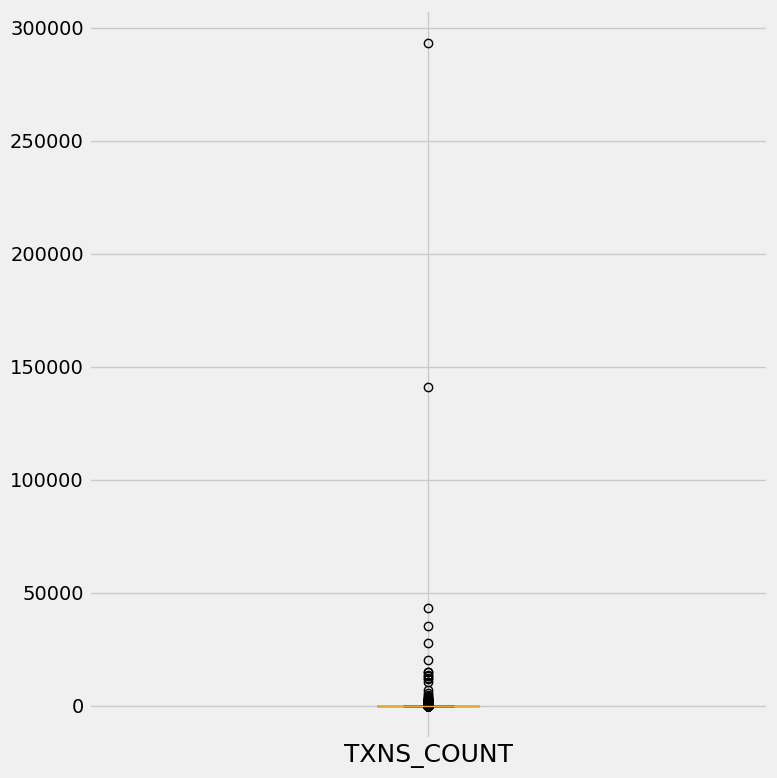

In [23]:
with plt.style.context('fivethirtyeight'):
    transaction_counts_by_wallet.boxplot(column = 'TXNS_COUNT', figsize = (8, 8))
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('TXNS_COUNT_1.png')

The main mass of values is not visible due to the presence of outliers - some users have made around 300 000, around 150 000, and around 50 000 transactions. The main cluster of values is somewhere below 5000 transactions.

Boxplot for wallets that have made fewer than 5000 transactions:

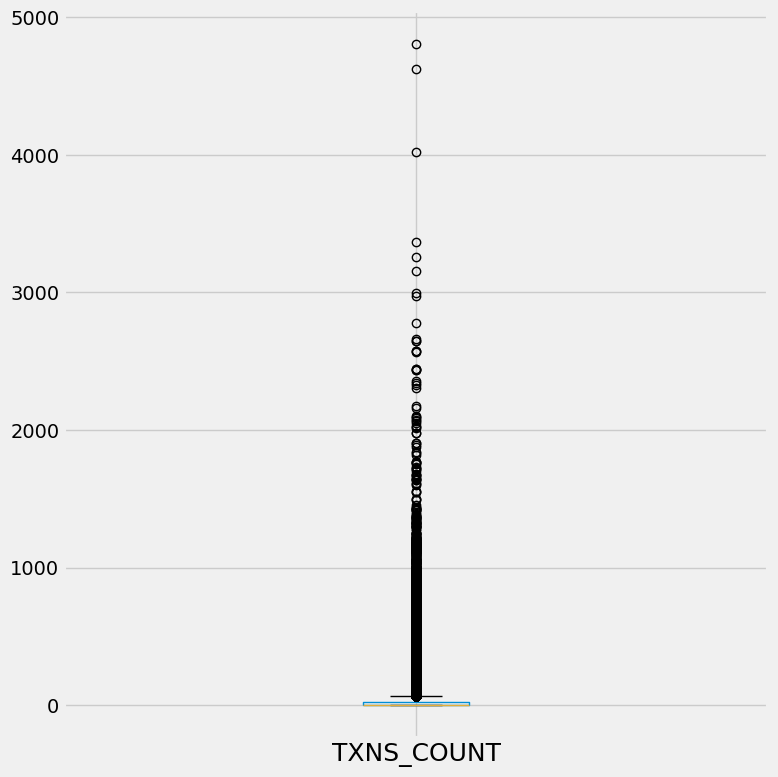

In [24]:
with plt.style.context('fivethirtyeight'):
    (
    transaction_counts_by_wallet[transaction_counts_by_wallet['TXNS_COUNT']<5000]
        .boxplot(column = 'TXNS_COUNT', figsize = (8, 8))
    )
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('TXNS_COUNT_2.png')

The main cluster of outliers is located from 1500 transactions, while the main sample is somewhere below.


Boxplot for wallets that have made fewer than 200 transactions:

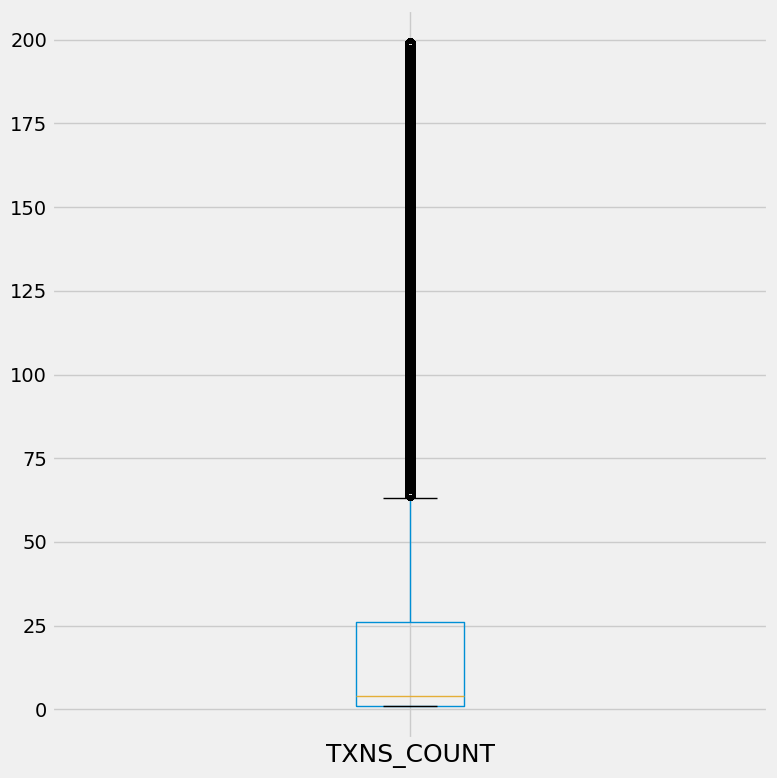

In [25]:
with plt.style.context('fivethirtyeight'):
    (
    transaction_counts_by_wallet[transaction_counts_by_wallet['TXNS_COUNT']<200]
        .boxplot(column = 'TXNS_COUNT', figsize = (8, 8))
    )
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('TXNS_COUNT_3.png')

Even around 60 transactions are still considered outliers.


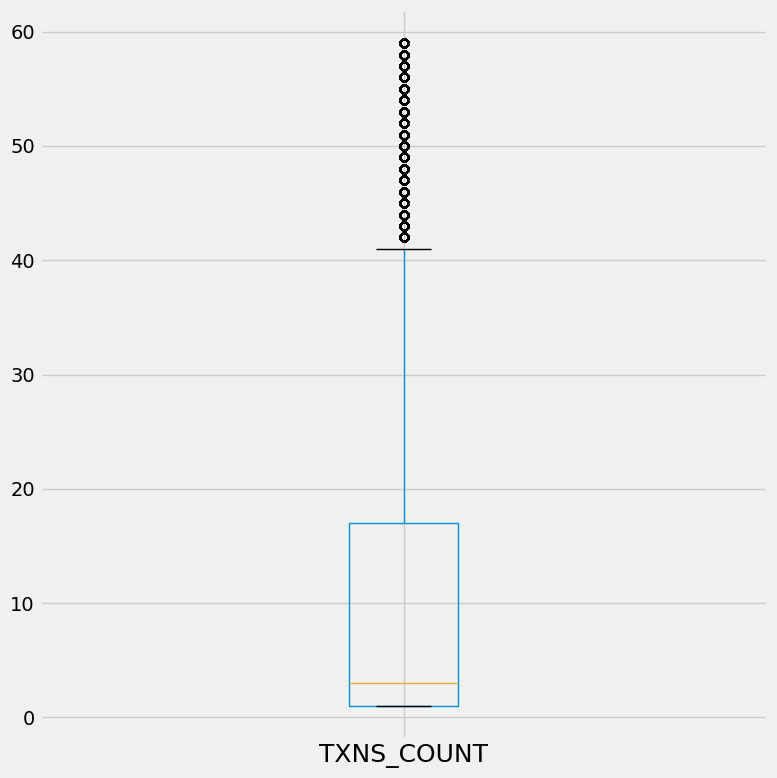

In [26]:
with plt.style.context('fivethirtyeight'):
    (
    transaction_counts_by_wallet[transaction_counts_by_wallet['TXNS_COUNT']<60]
        .boxplot(column = 'TXNS_COUNT', figsize = (8, 8))
    )
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('TXNS_COUNT_4.png')

In [29]:
transaction_counts_by_wallet['TXNS_COUNT'].median()

4.0

This graph represents a boxplot, a standardized way of displaying the distribution of data based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum.

- The yellow line (second quartile) is the median, which means 50% of users made 1-4 transactions.
-
From the yellow line to the end of the "box" (third quartile) represents the next 25% of users, who made more than 4 up to 17 transactions.

- The line ending with a black border (fourth quartile) represents the next 25% of users, who made from 17 to 41 transactions.

### How many is this in numbers:

1-4 transactions were made by 2,596,928 users:


In [30]:
transaction_counts_by_wallet[transaction_counts_by_wallet['TXNS_COUNT']<=4]['SENDER_WALLET'].count()

2596928

more than 4 and less than 18 transactions were made by 843,630 users:

In [31]:
transaction_counts_by_wallet[(transaction_counts_by_wallet['TXNS_COUNT']>4)&
                            (transaction_counts_by_wallet['TXNS_COUNT']<=17)]['SENDER_WALLET'].count()

843630

more than 17 and less than 42 transactions were made by 766,247 users:

In [32]:
transaction_counts_by_wallet[(transaction_counts_by_wallet['TXNS_COUNT']>17)&
                            (transaction_counts_by_wallet['TXNS_COUNT']<=41)]['SENDER_WALLET'].count()

766247

More than 41 transactions were made by 809,162 users. This group is the most diverse, as all values are statistical outliers - there are those who made 41 transactions, and there are those who made more than 300,000:

In [35]:
transaction_counts_by_wallet[transaction_counts_by_wallet['TXNS_COUNT']>41]['SENDER_WALLET'].count()

809162

For further analysis of user behavior to identify users who abuse the system, it is necessary to reduce the dataset. I think it would be reasonable to remove everyone up to the last segment of the boxplot - those who made 17 or fewer transactions. Of course, there may still be Sybils among them, but it is necessary to reduce the "noise" in the data to focus on those who have tried the most to manipulate the metrics.

In [18]:
df = df.merge(transaction_counts_by_wallet, on='SENDER_WALLET', how='left')

In [36]:
df

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT
0,Avalanche,0xb63e9f4ae49b3425509b342e4290a16aab67c04dbfa7...,Polygon,0x2e25362a166483e5738ac6548f5aa1536f15a348,2023-07-28 09:00:52,Stargate,NaN,0.009989,130.0
1,BNB Chain,0x3ce4df0f0b75a327037c5b4354c43e6028371e462d25...,Zora,0xa21de94fe09e7a5f336af05fb7de85c816bd8e5f,2024-02-11 14:56:41,Merkly,0.879799,NaN,95.0
2,BNB Chain,0x27d7bb3895cd0fdc046224227e10a42b00c8661e5854...,Zora,0xc0bb52df1500c0be33f90d0e0d0bbdda931df085,2024-02-23 13:09:29,Merkly,0.046499,NaN,16.0
3,BNB Chain,0x0e121b27e1aa5742a32e1b5d44b28641539bcf169da9...,Zora,0x4f9f8ed869ab66d1548c2f88754bf9d3b962cd6c,2024-03-01 09:07:37,Merkly,29.450207,NaN,133.0
4,Polygon,0x53ad08ef01ea459ad1dbfa387d9fc5146f07edb53b4b...,Tenet,0x78a6e3901d8fd3eb9886a0e3aea5d1a1bd74b5f8,2023-08-01 00:27:50,Merkly,0.006677,NaN,53.0
...,...,...,...,...,...,...,...,...,...
101063165,BNB Chain,0x0f5f2f92629a3babcc18dee80a1b1f92329e003a6393...,Harmony,0x9c72a3aeab9a1b78e4119c9fcd4e56e32ec43f25,2023-08-05 17:00:50,Harmony Bridge,NaN,NaN,116.0
101063166,Avalanche,0xf9aa59872cad3e2fbda5c9f4f011e4c828eaacffc6e4...,Polygon,0x0c6276d830caca7f217055fc6852aa90c68168bb,2023-07-04 05:41:30,Stargate,NaN,738.307805,42.0
101063167,Avalanche,0x6e385b4c078d984634d89001eeebefa4df9a72a39976...,Polygon,0x71f819ab5998d28ae6634208680dfdc9932be653,2023-07-04 05:57:13,Stargate,NaN,222.539953,104.0
101063168,Polygon,0xe3040cf978a4020e8ff9e284ca6eea4905a5962ebdfc...,Fuse Mainnet,0x40fd0ce9c146f7070350e8d23811a6cb19a3bac2,2024-02-22 10:16:15,Fuse Bridge,NaN,NaN,43.0


In [19]:
del transaction_counts_by_wallet

In [20]:
filter_user_by_tx_number = df['TXNS_COUNT']<=17

In [21]:
df_ready = df[~(filter_user_by_tx_number)]

In [26]:
df_ready

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT
0,Avalanche,0xb63e9f4ae49b3425509b342e4290a16aab67c04dbfa7...,Polygon,0x2e25362a166483e5738ac6548f5aa1536f15a348,2023-07-28 09:00:52,Stargate,NaN,0.009989,130.0
1,BNB Chain,0x3ce4df0f0b75a327037c5b4354c43e6028371e462d25...,Zora,0xa21de94fe09e7a5f336af05fb7de85c816bd8e5f,2024-02-11 14:56:41,Merkly,0.879799,NaN,95.0
3,BNB Chain,0x0e121b27e1aa5742a32e1b5d44b28641539bcf169da9...,Zora,0x4f9f8ed869ab66d1548c2f88754bf9d3b962cd6c,2024-03-01 09:07:37,Merkly,29.450207,NaN,133.0
4,Polygon,0x53ad08ef01ea459ad1dbfa387d9fc5146f07edb53b4b...,Tenet,0x78a6e3901d8fd3eb9886a0e3aea5d1a1bd74b5f8,2023-08-01 00:27:50,Merkly,0.006677,NaN,53.0
5,Arbitrum,0xa2f496a9626d3fb8488e228f24c0e01e6b09d42ad73c...,Fuse Mainnet,0xdc573959555c055aaa5b62810cb54847401f11cb,2024-04-09 17:39:04,Gas.zip,0.000044,NaN,27.0
...,...,...,...,...,...,...,...,...,...
101063164,Celo Mainnet,0x09b5bc17a0b4b48402de90bfa3153d4d3b959d0a865b...,Gnosis,0xf21b95549b8adf93e1232f20cf2eac2a07c8077f,2024-03-04 08:49:58,L2Pass,NaN,NaN,68.0
101063165,BNB Chain,0x0f5f2f92629a3babcc18dee80a1b1f92329e003a6393...,Harmony,0x9c72a3aeab9a1b78e4119c9fcd4e56e32ec43f25,2023-08-05 17:00:50,Harmony Bridge,NaN,NaN,116.0
101063166,Avalanche,0xf9aa59872cad3e2fbda5c9f4f011e4c828eaacffc6e4...,Polygon,0x0c6276d830caca7f217055fc6852aa90c68168bb,2023-07-04 05:41:30,Stargate,NaN,738.307805,42.0
101063167,Avalanche,0x6e385b4c078d984634d89001eeebefa4df9a72a39976...,Polygon,0x71f819ab5998d28ae6634208680dfdc9932be653,2023-07-04 05:57:13,Stargate,NaN,222.539953,104.0


In [26]:
del df

In [22]:
gc.collect()

0

# Analysis

I will split the time and date into different columns:

In [23]:
df_ready['DATE'] = df_ready['SOURCE_TIMESTAMP_UTC'].dt.date

<ipython-input-23-6d2e61ea9ee2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready['DATE'] = df_ready['SOURCE_TIMESTAMP_UTC'].dt.date


In [24]:
df_ready['TIME'] = df_ready['SOURCE_TIMESTAMP_UTC'].dt.time

<ipython-input-24-ec4469f7a0fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready['TIME'] = df_ready['SOURCE_TIMESTAMP_UTC'].dt.time


Sorting the dataset by date:

In [25]:
df_ready.sort_values(by='SOURCE_TIMESTAMP_UTC', inplace=True)

<ipython-input-25-309631007a7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready.sort_values(by='SOURCE_TIMESTAMP_UTC', inplace=True)


In [33]:
df_ready['SOURCE_TIMESTAMP_UTC']

68535742   2019-10-12 20:33:50
73833291   2019-10-13 15:21:00
45385157   2019-10-14 06:46:10
68921387   2021-12-03 14:33:48
15061772   2021-12-03 14:33:55
                   ...        
69827214   2024-05-01 23:59:54
87531311   2024-05-01 23:59:55
42548640   2024-05-01 23:59:57
96521252   2024-05-01 23:59:57
56712265   2024-05-01 23:59:58
Name: SOURCE_TIMESTAMP_UTC, Length: 88707482, dtype: datetime64[ns]

## 1. Searching for short "robotic" intervals between transactions

Counting the number of transactions users made each day:

In [27]:
txns_within_day_by_wallet = (
    df_ready.groupby(['SENDER_WALLET', 'DATE'])['SOURCE_TRANSACTION_HASH'].count()
    .reset_index(name='TXNS_WITHIN_DAY_COUNT')
)

In [35]:
txns_within_day_by_wallet

,SENDER_WALLET,DATE,TXNS_WITHIN_DAY_COUNT
0,0x00000000091b2041a94d32b05556c52028161b28,2023-04-16,3
1,0x00000000091b2041a94d32b05556c52028161b28,2023-06-16,3
2,0x00000000091b2041a94d32b05556c52028161b28,2023-06-29,17
3,0x00000000091b2041a94d32b05556c52028161b28,2023-06-30,1
4,0x00000000091b2041a94d32b05556c52028161b28,2023-07-01,1
...,...,...,...
33388437,0xfffffff7b612b0a07f0e30147dd6fad603e68d08,2023-09-26,1
33388438,0xfffffff7b612b0a07f0e30147dd6fad603e68d08,2023-10-02,2
33388439,0xfffffff7b612b0a07f0e30147dd6fad603e68d08,2023-10-05,9
33388440,0xfffffff7b612b0a07f0e30147dd6fad603e68d08,2023-10-26,4


Adding data to the overall dataset:

In [28]:
df_ready = df_ready.merge(txns_within_day_by_wallet, on=['SENDER_WALLET', 'DATE'], how='left')

In [37]:
df_ready

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT
0,Kava,0xaf44e941991a15c712fcd8718323f36360724a798af8...,Metis,0x499601e6283366aa34d782eda01b04157010bc1c,2019-10-12 20:33:50,Merkly,8.890423e-02,NaN,93.0,2019-10-12,20:33:50,1.0
1,Kava,0xa3427b6f1070947ecfd5b17681f7db93d29fa273733b...,Optimism,0xbda94a971b8d30586fa9b915aecd608f5a3d71db,2019-10-13 15:21:00,Abracadabra Money,NaN,NaN,471.0,2019-10-13,15:21:00,1.0
2,Kava,0x68faeaefcd2e56aa37673ec6779e96e00002b2813829...,Linea,0x49e5505ed54d753a55c6a43cde247e7b8fe26927,2019-10-14 06:46:10,Stargate,NaN,NaN,250.0,2019-10-14,06:46:10,1.0
3,Fantom,0xa29ec9e78689f5a645ed18192666fc49f8e04e66c592...,NaN,0x51edab02afb55fd7cd54b145983dc72835ad2605,2021-12-03 14:33:48,ShimmerBridge,NaN,NaN,35.0,2021-12-03,14:33:48,1.0
4,Fantom,0x7327972b5230ca24d30ac46ba8ed1de0a84cfff83552...,Fuse Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2021-12-03 14:33:55,Merkly,1.730753e-04,NaN,65.0,2021-12-03,14:33:55,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
88707477,Linea,0xc37d516296cfdd3f9cb34ce372909be5909a35ae41de...,Optimism,0x892f5b1681f3be235b60b9ed6f117813721a08ee,2024-05-01 23:59:54,Stargate,NaN,562.418752,52.0,2024-05-01,23:59:54,1.0
88707478,Polygon,0x036061a7f480a58750a9972038942e49d3eaca351cf3...,DFK,0x820ce808b7f6f59f716eda0a97299c8e31ac791c,2024-05-01 23:59:55,Merkly,NaN,NaN,25.0,2024-05-01,23:59:55,4.0
88707479,Celo Mainnet,0xe9baeb73646ca5508cb98310ca603e9f326671f11155...,Fuse Mainnet,0x38ba7226063c93a6cefcfc373eac9eedbf1bb145,2024-05-01 23:59:57,Merkly,6.041590e-07,NaN,46.0,2024-05-01,23:59:57,8.0
88707480,Celo Mainnet,0x9ac6db46b4b7edcbe7ed7f7ed54e59c2b998bd38ac97...,Gnosis,0x57111a32ae4169a222836ed83f21c05927f72523,2024-05-01 23:59:57,Angle,NaN,NaN,115.0,2024-05-01,23:59:57,2.0


In [29]:
del txns_within_day_by_wallet

In [30]:
gc.collect()

0

Calculating the time in minutes between intervals, if there is 1 transaction per day, it will be NaN, also if the first iteration is for the day, it will be NaN, and then the time between intervals:

In [31]:
df_ready['INTERVAL_MINUTES'] = (
    df_ready.groupby(['SENDER_WALLET', 'DATE'])['SOURCE_TIMESTAMP_UTC']
    .diff().dt.total_seconds() / 60
)

In [46]:
df_ready.head()

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES
0,Kava,0xaf44e941991a15c712fcd8718323f36360724a798af8...,Metis,0x499601e6283366aa34d782eda01b04157010bc1c,2019-10-12 20:33:50,Merkly,0.088904,NaN,93.0,2019-10-12,20:33:50,1.0,NaN
1,Kava,0xa3427b6f1070947ecfd5b17681f7db93d29fa273733b...,Optimism,0xbda94a971b8d30586fa9b915aecd608f5a3d71db,2019-10-13 15:21:00,Abracadabra Money,NaN,NaN,471.0,2019-10-13,15:21:00,1.0,NaN
2,Kava,0x68faeaefcd2e56aa37673ec6779e96e00002b2813829...,Linea,0x49e5505ed54d753a55c6a43cde247e7b8fe26927,2019-10-14 06:46:10,Stargate,NaN,NaN,250.0,2019-10-14,06:46:10,1.0,NaN
3,Fantom,0xa29ec9e78689f5a645ed18192666fc49f8e04e66c592...,NaN,0x51edab02afb55fd7cd54b145983dc72835ad2605,2021-12-03 14:33:48,ShimmerBridge,NaN,NaN,35.0,2021-12-03,14:33:48,1.0,NaN
4,Fantom,0x7327972b5230ca24d30ac46ba8ed1de0a84cfff83552...,Fuse Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2021-12-03 14:33:55,Merkly,0.000173,NaN,65.0,2021-12-03,14:33:55,1.0,NaN


In [33]:
df_ready.dropna(subset=['TXNS_COUNT', 'TXNS_WITHIN_DAY_COUNT'], inplace=True)

In [34]:
df_ready[['TXNS_COUNT', 'TXNS_WITHIN_DAY_COUNT']] = df_ready[['TXNS_COUNT', 'TXNS_WITHIN_DAY_COUNT']].astype(int)

Boxplot of the interval between transactions for users with more than 1 transaction per day:

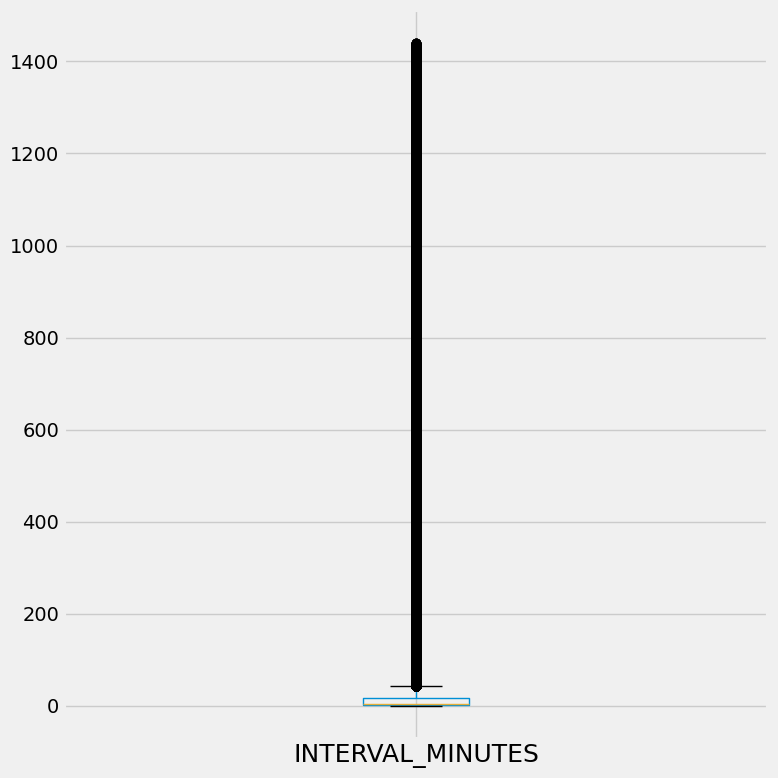

In [35]:
with plt.style.context('fivethirtyeight'):
    (
    df_ready[df_ready['TXNS_WITHIN_DAY_COUNT']>1]
        .boxplot(column = 'INTERVAL_MINUTES', figsize = (8, 8))
    )
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('INTERVAL_MINUTES_1.png')

There are many outliers, limiting INTERVAL_MINUTES to 80 minutes:


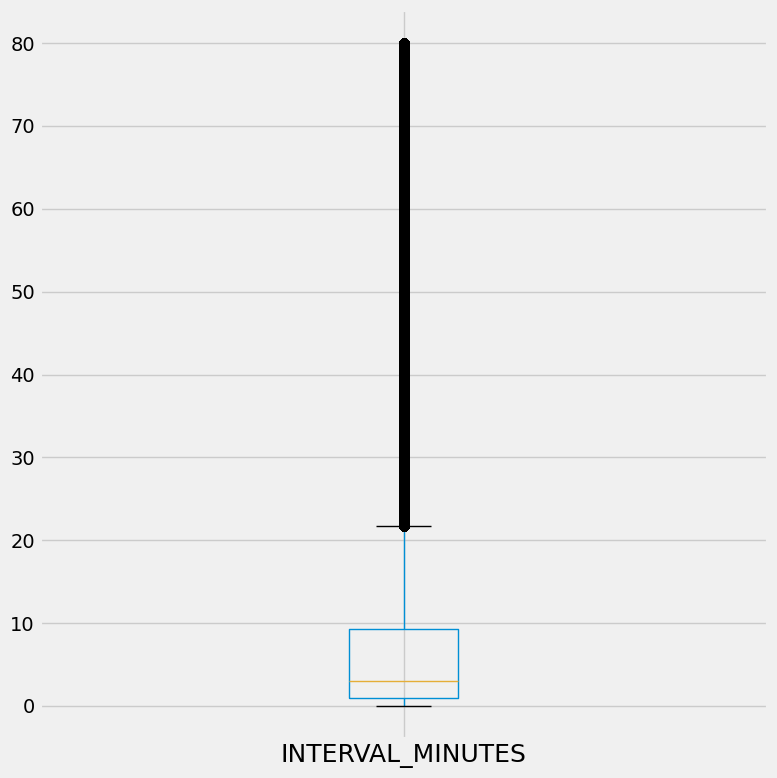

In [36]:
with plt.style.context('fivethirtyeight'):
    (
    df_ready[(df_ready['TXNS_WITHIN_DAY_COUNT']>1)&
          (df_ready['INTERVAL_MINUTES']<80)]
        .boxplot(column = 'INTERVAL_MINUTES', figsize = (8, 8))
    )
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('INTERVAL_MINUTES_2.png')

In the first quartile, there are users with intervals of approximately 1 minute.


More precisely in numbers, percentiles are chosen by 20%:


In [37]:
(df_ready[(df_ready['TXNS_WITHIN_DAY_COUNT']>1)&(df_ready['INTERVAL_MINUTES']<80)]
['INTERVAL_MINUTES'].quantile([.2, .4, .6, .8]).to_dict())

{0.2: 0.6666666666666666, 0.4: 2.0833333333333335, 0.6: 4.5, 0.8: 12.8}

In the first segment, users have intervals from 0 seconds to 60 seconds.


What is the distribution among those who have intervals less than 60 seconds:


In [38]:
df_ready[df_ready['INTERVAL_MINUTES']<0.66]['INTERVAL_MINUTES'].quantile([.2, .4, .6, .8]).to_dict()

{0.2: 0.08333333333333333, 0.4: 0.21666666666666667, 0.6: 0.35, 0.8: 0.5}

This means that among users with intervals up to 0,66 seconds, 20% have transactions with intervals up to 8 seconds, the next 20% from 8 to 0.21 seconds, the next from 21 to 35, the next from 35 to 50 seconds, and further more than 50 seconds. I think the shortest intervals should be the first 20% - from 0 seconds to 8 seconds. I will calculate how many such short transactions there are for users:

In [39]:
less_than_8_sec_interval = (df_ready[df_ready['INTERVAL_MINUTES']<=0.083]
                               .groupby(['SENDER_WALLET'])['INTERVAL_MINUTES']
                             .count()
                             .reset_index(name='LESS_8_SEC_COUNT'))

In [40]:
df_ready = df_ready.merge(less_than_8_sec_interval, on='SENDER_WALLET', how='left')

In [41]:
df_ready

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,LESS_8_SEC_COUNT
0,Kava,0xaf44e941991a15c712fcd8718323f36360724a798af8...,Metis,0x499601e6283366aa34d782eda01b04157010bc1c,2019-10-12 20:33:50,Merkly,8.890423e-02,NaN,93,2019-10-12,20:33:50,1,NaN,1.0
1,Kava,0xa3427b6f1070947ecfd5b17681f7db93d29fa273733b...,Optimism,0xbda94a971b8d30586fa9b915aecd608f5a3d71db,2019-10-13 15:21:00,Abracadabra Money,NaN,NaN,471,2019-10-13,15:21:00,1,NaN,1.0
2,Kava,0x68faeaefcd2e56aa37673ec6779e96e00002b2813829...,Linea,0x49e5505ed54d753a55c6a43cde247e7b8fe26927,2019-10-14 06:46:10,Stargate,NaN,NaN,250,2019-10-14,06:46:10,1,NaN,NaN
3,Fantom,0xa29ec9e78689f5a645ed18192666fc49f8e04e66c592...,NaN,0x51edab02afb55fd7cd54b145983dc72835ad2605,2021-12-03 14:33:48,ShimmerBridge,NaN,NaN,35,2021-12-03,14:33:48,1,NaN,NaN
4,Fantom,0x7327972b5230ca24d30ac46ba8ed1de0a84cfff83552...,Fuse Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2021-12-03 14:33:55,Merkly,1.730753e-04,NaN,65,2021-12-03,14:33:55,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88657601,Linea,0xc37d516296cfdd3f9cb34ce372909be5909a35ae41de...,Optimism,0x892f5b1681f3be235b60b9ed6f117813721a08ee,2024-05-01 23:59:54,Stargate,NaN,562.418752,52,2024-05-01,23:59:54,1,NaN,7.0
88657602,Polygon,0x036061a7f480a58750a9972038942e49d3eaca351cf3...,DFK,0x820ce808b7f6f59f716eda0a97299c8e31ac791c,2024-05-01 23:59:55,Merkly,NaN,NaN,25,2024-05-01,23:59:55,4,2.966667,NaN
88657603,Celo Mainnet,0xe9baeb73646ca5508cb98310ca603e9f326671f11155...,Fuse Mainnet,0x38ba7226063c93a6cefcfc373eac9eedbf1bb145,2024-05-01 23:59:57,Merkly,6.041590e-07,NaN,46,2024-05-01,23:59:57,8,41.683333,NaN
88657604,Celo Mainnet,0x9ac6db46b4b7edcbe7ed7f7ed54e59c2b998bd38ac97...,Gnosis,0x57111a32ae4169a222836ed83f21c05927f72523,2024-05-01 23:59:57,Angle,NaN,NaN,115,2024-05-01,23:59:57,2,1.533333,NaN


In [42]:
del less_than_8_sec_interval

Let's consider these accounts from different angles.



Slice for users who made more than 1 transaction with an interval of 8 seconds or less. Percentiles 20%:

In [45]:
(
    df_ready[df_ready['LESS_8_SEC_COUNT']>=1].groupby('SENDER_WALLET')
    ['LESS_8_SEC_COUNT'].first().reset_index()['LESS_8_SEC_COUNT']
    .quantile([.2, .4, .6, .8]).to_dict()

)

{0.2: 1.0, 0.4: 2.0, 0.6: 4.0, 0.8: 10.0}

20% of the sample made 1 transaction with a short interval, the next 20% made 2 short transactions, the next 20% made between 2 to 4 short transactions, the next made between 4 to 10 short transactions, and the last 20% made more than 10 short transactions.

Quantitative count:


In [46]:
(
    df_ready[df_ready['LESS_8_SEC_COUNT']>=1].groupby('SENDER_WALLET')
    ['LESS_8_SEC_COUNT'].first().reset_index()['LESS_8_SEC_COUNT'].value_counts()

)

LESS_8_SEC_COUNT
1.0      72709
2.0      28667
3.0      17813
4.0      12989
5.0      10138
         ...  
247.0        1
180.0        1
569.0        1
632.0        1
296.0        1
Name: count, Length: 312, dtype: int64

72709 accounts made 1 transaction with a short interval, 28667 accounts made 2, 17813 accounts made 3, and so on. There are accounts that made 569 or 632 such transactions.

I think we can confidently include accounts with 3 or more such transactions in the Sybil list, but accounts with 2 such transactions raise questions. To make a decision, I will look at several examples.

Slice for accounts with 2 short transactions:


In [47]:
df_ready[df_ready['LESS_8_SEC_COUNT'] == 2][['SENDER_WALLET', 'TXNS_COUNT']]

,SENDER_WALLET,TXNS_COUNT
254,0x784ca853277fe20b17c06c63958add91b047c166,255
257,0x784ca853277fe20b17c06c63958add91b047c166,255
302,0xc1212c6c96965ba05aa246fa32cd1717e9ecfafb,910
398,0xc1212c6c96965ba05aa246fa32cd1717e9ecfafb,910
889,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,40
...,...,...
88657396,0x478a3565e474cb46e45312c08796a19541fe1859,93
88657446,0x956124621bbc5f8eba2a4c1282a3f15e74814fb0,396
88657485,0x956124621bbc5f8eba2a4c1282a3f15e74814fb0,396
88657533,0x956124621bbc5f8eba2a4c1282a3f15e74814fb0,396


Example #1 from the list:


In [51]:
(
    df_ready[df_ready['SENDER_WALLET'] == '0x784ca853277fe20b17c06c63958add91b047c166']
    [['SOURCE_CHAIN', 'DESTINATION_CHAIN', 'SOURCE_TIMESTAMP_UTC',
      'TXNS_WITHIN_DAY_COUNT', 'INTERVAL_MINUTES']].head(60)
)

,SOURCE_CHAIN,DESTINATION_CHAIN,SOURCE_TIMESTAMP_UTC,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES
254,Harmony,DFK,2022-09-07 16:50:24,2,NaN
257,Harmony,DFK,2022-09-07 16:53:49,2,3.416667
20728,Harmony,DFK,2022-09-14 21:10:32,1,NaN
26689,Harmony,DFK,2022-09-15 09:53:32,2,NaN
26691,Harmony,DFK,2022-09-15 09:54:14,2,0.700000
44628,Harmony,DFK,2022-09-17 09:18:15,1,NaN
66112,Harmony,DFK,2022-09-21 12:24:09,28,NaN
66115,Harmony,DFK,2022-09-21 12:24:29,28,0.333333
66119,Harmony,DFK,2022-09-21 12:24:43,28,0.233333
66133,Harmony,DFK,2022-09-21 12:25:37,28,0.900000


This account made a total of 255 transactions. I didn't even get to the transactions with an interval of less than 8 seconds because at the very beginning of the list, there is a series of similar transactions with very short intervals.

Example #2 from the list:

In [53]:
df_ready[df_ready['SENDER_WALLET'] == '0xbcd623d028b059a053fc397eb6674d835b5e3c9d']

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,LESS_8_SEC_COUNT
889,Optimism,0x9688ba7087e3d18786503a325a291a53188d93bbe480...,Polygon,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-09-08 00:57:22,Stargate,NaN,260.566302,40,2022-09-08,00:57:22,1,NaN,2.0
94544,Optimism,0xe75e09ba841cb23181264d36f807140111ef436f2b49...,Arbitrum,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-09-27 05:02:53,Stargate,NaN,100.939400,40,2022-09-27,05:02:53,1,NaN,2.0
116575,Optimism,0x2aee4e54823dd27cff08e9f3cef6ced10c83252f5eba...,Arbitrum,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-10-02 09:20:08,Stargator,NaN,NaN,40,2022-10-02,09:20:08,1,NaN,2.0
476281,Optimism,0xa8836e232649693f43b9c05ae5b937d6bce1b8f8152a...,BNB Chain,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-12-05 17:33:08,Stargate,NaN,102.938200,40,2022-12-05,17:33:08,1,NaN,2.0
486766,BNB Chain,0x9f85ceb820c76e9f523b2d3db2b6e7e9b6dade760536...,Arbitrum,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-12-06 15:33:12,Stargate,NaN,0.028791,40,2022-12-06,15:33:12,1,NaN,2.0
563733,Polygon,0xf4094eaa2d8dfba9db3d81bb6e9866b2eeef0e592469...,Avalanche,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-12-16 13:41:54,Stargate,NaN,0.199876,40,2022-12-16,13:41:54,1,NaN,2.0
575724,BNB Chain,0xbbde4eef35bbc2416c49572dee284689b8efb2e59cd8...,Arbitrum,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-12-18 11:36:52,Stargate,NaN,101.006478,40,2022-12-18,11:36:52,1,NaN,2.0
592476,BNB Chain,0xf6594ce5487d93f2c1cdf8dc970fe1936022fd00b4a4...,Optimism,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2022-12-20 12:50:50,Stargate,NaN,10.984820,40,2022-12-20,12:50:50,1,NaN,2.0
714286,BNB Chain,0x8116041564d0d41d5f53cc5fccdab0705585617ef9c6...,Avalanche,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2023-01-07 01:28:03,Stargate,NaN,336.792836,40,2023-01-07,01:28:03,1,NaN,2.0
726104,Avalanche,0xc6f32f0cd12b96024118554bd875b6aa34baca1bfc36...,Polygon,0xbcd623d028b059a053fc397eb6674d835b5e3c9d,2023-01-08 13:06:29,Stargate,NaN,336.872649,40,2023-01-08,13:06:29,1,NaN,2.0


3 transactions with intervals of 6 and 5 seconds, also with identical amounts in these transactions: Stargate - 49.922655 USD.

Example #3 from the list:

In [56]:
df_ready[df_ready['SENDER_WALLET'] == '0x478a3565e474cb46e45312c08796a19541fe1859'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,LESS_8_SEC_COUNT
6623294,Polygon,0x99acf19fbc4a987562421bf924aba8d231aed2f7778d...,Fantom,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-12 00:42:38,Stargate,NaN,0.519298,93,2023-05-12,00:42:38,3,NaN,2.0
6627021,Polygon,0x0a23ee42ae422f66b98ca812ca93e3b054241282be4c...,Fantom,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-12 01:54:37,Stargate,NaN,0.257917,93,2023-05-12,01:54:37,3,71.983333,2.0
6642942,Fantom,0x3efc8beeba1865b0e131e66ff49f0449644ea01d26c9...,Polygon,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-12 05:21:44,Stargate,NaN,0.339986,93,2023-05-12,05:21:44,3,207.116667,2.0
6800879,Fantom,0xc6543390d3e9242eb1ed16b1893dddf702cb4c49d8e6...,Avalanche,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-13 00:01:48,Stargate,NaN,0.026608,93,2023-05-13,00:01:48,5,NaN,2.0
6864951,Fantom,0x24109e69d37ce3214674919406ed01bdf821f6cc7ef9...,BNB Chain,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-13 09:54:38,Stargate,NaN,0.022485,93,2023-05-13,09:54:38,5,592.833333,2.0
6891392,Fantom,0x0c665846808da9cb81ef0b179ada306c84c4d701f85e...,Arbitrum,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-13 12:30:53,Stargate,NaN,0.015850,93,2023-05-13,12:30:53,5,156.250000,2.0
6946446,Polygon,0xa80a69786ebabb2569d33a7fb3ff9085a795fa31e09e...,Fantom,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-13 18:24:04,Stargate,NaN,0.398505,93,2023-05-13,18:24:04,5,353.183333,2.0
6974042,Fantom,0xb1a5b9726edccb45f37a5a5d051cdaa3892ee9375946...,Polygon,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-13 21:52:28,Stargate,NaN,0.376358,93,2023-05-13,21:52:28,5,208.400000,2.0
7070130,Polygon,0x87c5eb1a13e6bb5c9c4a934095c1f99636568669031a...,Fantom,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-14 11:03:30,Stargate,NaN,0.316159,93,2023-05-14,11:03:30,2,NaN,2.0
7142317,Fantom,0x9889391f189c4e67adb436cf32bed938a9604b5459dc...,Polygon,0x478a3565e474cb46e45312c08796a19541fe1859,2023-05-14 17:53:16,Stargate,NaN,0.300711,93,2023-05-14,17:53:16,2,409.766667,2.0


13 transactions with very short intervals, some of which have 0 seconds intervals, from BNB Chain to Kava and Moonbeam through Merkly.


**I think all three examples taken from the list manually can be interpreted as Sybils, so accounts with 2 short intervals will be added to the list.**<br> Also, the last example inspired me to look at examples of accounts with 1 short transaction.

To be slightly more objective, I will add a count of the number of intervals from the second percentile - from 8 секунда minutes to 21 секунды:

In [57]:
less_than_21_sec_interval = (df_ready[(df_ready['INTERVAL_MINUTES']>=0.08)&
                                   (df_ready['INTERVAL_MINUTES']<=0.21)]
                               .groupby(['SENDER_WALLET'])['INTERVAL_MINUTES']
                             .count()
                             .reset_index(name='LESS_21_SEC_COUNT'))

In [58]:
df_ready = df_ready.merge(less_than_21_sec_interval, on='SENDER_WALLET', how='left')

In [60]:
del less_than_21_sec_interval

Taking a slice of users who have one interval between transactions less than 8 seconds, and also have more than 1 interval less than 21 seconds:

In [62]:
df_ready[(df_ready['LESS_8_SEC_COUNT'] == 1)&(df_ready['LESS_21_SEC_COUNT'] > 1)][['SENDER_WALLET', 'TXNS_COUNT']]

,SENDER_WALLET,TXNS_COUNT
1,0xbda94a971b8d30586fa9b915aecd608f5a3d71db,471
256,0xe71555470520c29eb560c43d9aa6855b0808fa84,1007
262,0xe71555470520c29eb560c43d9aa6855b0808fa84,1007
267,0xe71555470520c29eb560c43d9aa6855b0808fa84,1007
273,0xe71555470520c29eb560c43d9aa6855b0808fa84,1007
...,...,...
88657412,0x3ec2f2ad041598f511158dda7907b3b746240971,125
88657470,0xa4c31731946e00a07d8fbfa3cfcf96716c04da3d,80
88657490,0xbc61933d21ada45ba53044804cfd3e8b2831b531,75
88657495,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,78


Example #1 from the list:

In [63]:
df_ready[df_ready['SENDER_WALLET'] == '0xbc61933d21ada45ba53044804cfd3e8b2831b531'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,LESS_8_SEC_COUNT,LESS_21_SEC_COUNT
84122698,Arbitrum,0xdb49d40c41b25d0785442d9e0ece8bcb4a3a93a68f4a...,Fantom,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-03 20:52:25,Gas.zip,NaN,NaN,75,2024-04-03,20:52:25,2,NaN,1.0,6.0
84138278,Arbitrum,0x540c1ef81f20d04e68d4610732932ffed135c4c4adfd...,NaN,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-03 23:43:06,Aptos Bridge,NaN,NaN,75,2024-04-03,23:43:06,2,170.683333,1.0,6.0
84174380,BNB Chain,0x2e87f472ca79ce7287e231211eba940a2b3207c206c3...,NaN,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-04 06:50:00,Aptos Bridge,NaN,NaN,75,2024-04-04,06:50:00,2,NaN,1.0,6.0
84203011,Polygon,0x777d145f40da03bdcd403dfa90409cee702f30603d9e...,Avalanche,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-04 10:25:34,Stargate,NaN,1263.302586,75,2024-04-04,10:25:34,2,215.566667,1.0,6.0
85677540,Arbitrum,0xb7b702fc61e0aca53852d4cbb37edf120fc8833ae5c3...,Kava,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-13 00:54:34,Gas.zip,0.770675,NaN,75,2024-04-13,00:54:34,25,NaN,1.0,6.0
85677768,Avalanche,0x8bea270b3f666389073c825eb7db94ab7d62d1f26972...,Meter Mainnet,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-13 00:57:33,Merkly,NaN,NaN,75,2024-04-13,00:57:33,25,2.983333,1.0,6.0
85677791,Avalanche,0xebec6aab6b81207c81982888a9d2a41fccb0d361fc5b...,Tenet,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-13 00:57:48,Merkly,NaN,NaN,75,2024-04-13,00:57:48,25,0.250000,1.0,6.0
85677806,Avalanche,0x1eb87d86992cb41a6c7c9b6904d690310ea6ccaa6466...,Optimism,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-13 00:58:00,Merkly,NaN,NaN,75,2024-04-13,00:58:00,25,0.200000,1.0,6.0
85677905,Manta,0xec14981df8d2163371b62d8de18560e340278dc4c603...,Moonbeam,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-13 00:59:29,Merkly,NaN,NaN,75,2024-04-13,00:59:29,25,1.483333,1.0,6.0
85677906,Manta,0x99b076c580633d0cc4d87118a4b472fc22d6c8a374c0...,Arbitrum,0xbc61933d21ada45ba53044804cfd3e8b2831b531,2024-04-13 00:59:29,Merkly,NaN,NaN,75,2024-04-13,00:59:29,25,0.000000,1.0,6.0


A series of 25 transactions with very short intervals, including 0 seconds. All transactions are from different networks to different networks.

Example #2 from the list:

In [64]:
df_ready[df_ready['SENDER_WALLET'] == '0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,LESS_8_SEC_COUNT,LESS_21_SEC_COUNT
84925626,Arbitrum,0x947b8d2ac12e87c78e54d74284beb05212a37a1ff208...,Fantom,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 15:52:14,Gas.zip,NaN,NaN,78,2024-04-08,15:52:14,26,NaN,1.0,2.0
84942392,Arbitrum,0x2d045c408e44851a02f4ce59ea10dff8c889e0831cde...,NaN,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 18:21:45,Aptos Bridge,NaN,NaN,78,2024-04-08,18:21:45,26,149.516667,1.0,2.0
84943255,BNB Chain,0xcecfb4f54fae74ab40f3a1536bcfecd1b3333b839393...,NaN,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 18:29:08,Aptos Bridge,NaN,NaN,78,2024-04-08,18:29:08,26,7.383333,1.0,2.0
84945986,Polygon,0x4ded5519600109f5b1b6f765a87833f6bbe8057414b3...,Avalanche,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 18:55:37,Stargate,NaN,1212.949848,78,2024-04-08,18:55:37,26,26.483333,1.0,2.0
84959100,Arbitrum,0x778032381916c59c1804b2b6512f47c7002fab45c693...,Avalanche,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 20:59:00,Merkly,5.004402,NaN,78,2024-04-08,20:59:00,26,123.383333,1.0,2.0
84959331,Avalanche,0x75bf474a6a839f2769abf75e33e13de313c7f76fc095...,Optimism,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 21:01:10,Merkly,NaN,NaN,78,2024-04-08,21:01:10,26,2.166667,1.0,2.0
84959356,Avalanche,0x950ca7042706c8776eb317c47f05e26165eeebe07b11...,Gnosis,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 21:01:26,Merkly,NaN,NaN,78,2024-04-08,21:01:26,26,0.266667,1.0,2.0
84959374,Avalanche,0x0f394541d4929c5efd3db6d0353afa55f02be0cd8ca4...,Celo Mainnet,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 21:01:40,Merkly,NaN,NaN,78,2024-04-08,21:01:40,26,0.233333,1.0,2.0
84959402,Avalanche,0xeff4a10e1ba869f018d77ed346a5bb872b9d571b5c45...,Arbitrum,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 21:01:54,Merkly,NaN,NaN,78,2024-04-08,21:01:54,26,0.233333,1.0,2.0
84959540,Arbitrum,0xaa09b550404a4137a6b9ae746242a0a4c580f1aaae0c...,Fantom,0x00286e56b210d91ecd0d0a3009c3c9ce2d111ac5,2024-04-08 21:03:26,Merkly,4.114472,NaN,78,2024-04-08,21:03:26,26,1.533333,1.0,2.0


26 transactions per session with different intervals, including short intervals, including 0 seconds. Also, very similar amounts in transactions indicate weak randomization when using software.

**Based on 2 randomly selected examples, I conclude that the presence of short transactions up to 21 seconds and the presence of transactions from 0 to 21 seconds indicate the use of software in these accounts.**

### List formation

Accounts with 2 very short transactions:

In [65]:
less_than_8_sec_list = (df_ready[df_ready['LESS_8_SEC_COUNT'] >= 2]['SENDER_WALLET'].unique().tolist())

In [66]:
len(less_than_8_sec_list)

142466

Accounts that meet both conditions:

- Have one transaction with an interval up to 8 seconds.
- Have transactions with intervals from 8 to 21 seconds.

In [68]:
list_less_8_sec_and_less_21sec = (df_ready[(df_ready['LESS_8_SEC_COUNT'] == 1)&
        (df_ready['LESS_21_SEC_COUNT'] > 1)]
 ['SENDER_WALLET'].unique().tolist())

In [69]:
len(list_less_8_sec_and_less_21sec)

23891

In [70]:
less_than_8_sec_list.extend(list_less_8_sec_and_less_21sec)


In [71]:
list_of_sybils_with_short_intervals = less_than_8_sec_list

In [72]:
len(list_of_sybils_with_short_intervals)

166357

In [73]:
with open('sybils_first_list.txt', 'w') as file:
    for item in list_of_sybils_with_short_intervals:
        file.write("%s\n" % item)

### Deleting transactions from these addresses from the overall dataset

In [74]:
df_after_filtering = df_ready[~df_ready['SENDER_WALLET'].isin(list_of_sybils_with_short_intervals)]

In [75]:
df_after_filtering

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,LESS_8_SEC_COUNT,LESS_21_SEC_COUNT
0,Kava,0xaf44e941991a15c712fcd8718323f36360724a798af8...,Metis,0x499601e6283366aa34d782eda01b04157010bc1c,2019-10-12 20:33:50,Merkly,8.890423e-02,NaN,93,2019-10-12,20:33:50,1,NaN,1.0,NaN
2,Kava,0x68faeaefcd2e56aa37673ec6779e96e00002b2813829...,Linea,0x49e5505ed54d753a55c6a43cde247e7b8fe26927,2019-10-14 06:46:10,Stargate,NaN,NaN,250,2019-10-14,06:46:10,1,NaN,NaN,NaN
3,Fantom,0xa29ec9e78689f5a645ed18192666fc49f8e04e66c592...,NaN,0x51edab02afb55fd7cd54b145983dc72835ad2605,2021-12-03 14:33:48,ShimmerBridge,NaN,NaN,35,2021-12-03,14:33:48,1,NaN,NaN,NaN
4,Fantom,0x7327972b5230ca24d30ac46ba8ed1de0a84cfff83552...,Fuse Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2021-12-03 14:33:55,Merkly,1.730753e-04,NaN,65,2021-12-03,14:33:55,1,NaN,NaN,NaN
82,Ethereum,0xf14eb7aead9baf48bd6604ae30de93b0af278c166250...,Avalanche,0x6d9f1a927cbcb5e2c28d13ca735bc6d6131406da,2022-09-07 14:21:51,Stargate,NaN,0.998382,844,2022-09-07,14:21:51,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88657598,Core Blockchain Mainnet,0xc5894ea0414d59358dfc03f4a11ae2ade295493f35ae...,Avalanche,0xe1d144b65cd16b7305d9059f79c4586adc5d4509,2024-05-01 23:59:53,Bitcoin Bridge,NaN,NaN,117,2024-05-01,23:59:53,7,1.400000,NaN,NaN
88657602,Polygon,0x036061a7f480a58750a9972038942e49d3eaca351cf3...,DFK,0x820ce808b7f6f59f716eda0a97299c8e31ac791c,2024-05-01 23:59:55,Merkly,NaN,NaN,25,2024-05-01,23:59:55,4,2.966667,NaN,NaN
88657603,Celo Mainnet,0xe9baeb73646ca5508cb98310ca603e9f326671f11155...,Fuse Mainnet,0x38ba7226063c93a6cefcfc373eac9eedbf1bb145,2024-05-01 23:59:57,Merkly,6.041590e-07,NaN,46,2024-05-01,23:59:57,8,41.683333,NaN,NaN
88657604,Celo Mainnet,0x9ac6db46b4b7edcbe7ed7f7ed54e59c2b998bd38ac97...,Gnosis,0x57111a32ae4169a222836ed83f21c05927f72523,2024-05-01 23:59:57,Angle,NaN,NaN,115,2024-05-01,23:59:57,2,1.533333,NaN,NaN


In [76]:
del df_ready

In [77]:
gc.collect()

238

## 2. Identifying weak randomization when using automation

The idea of this point is that accounts using software randomize the values of certain parameters, including:

- the number of transactions per session
- intervals between transactions<br>

The software uses something like the python random module and functions like randint() and choice(). We can try to find transactions where there was "weak" randomization, when the user set short ranges.

### How to do this

Calculate the median and mean of each parameter, and then divide the mean by the median. The closer the value is to 1, the weaker the randomization. Here's how it works:

- The median is a stable parameter that points exactly to the middle of all sorted values.
- The mean is subject to strong fluctuations; the greater the difference between the values, the more the mean will be "pulled" towards the outlier.<br>
<br>
The more similar the median and the mean, the less the values in the sample differ, i.e., the weaker the randomization.

To start, I will identify accounts that did not make multiple transactions in one day, i.e., 1 day - 1 transaction. In such accounts, it is not possible to determine randomization based on the number of transactions per session and the randomization of intervals between transactions.

The number of intervals between transactions, if there are 0 intervals, means that the user did not have multiple transactions on any day:


In [78]:
txns_interval_count = (
    df_after_filtering.groupby('SENDER_WALLET')['INTERVAL_MINUTES']
    .count().reset_index(name='NUM_OF_INTERVALS')
)

In [79]:
df_after_filtering = df_after_filtering.merge(txns_interval_count, on='SENDER_WALLET', how='left')

In [82]:
del txns_interval_count

In [83]:
df_after_filtering = df_after_filtering[df_after_filtering['NUM_OF_INTERVALS'] != 0 ]

To better calculate the ratio of the median to the mean, it is necessary to limit the sample so that the median and mean values themselves are more objective.

Boxplot of the number of intervals:

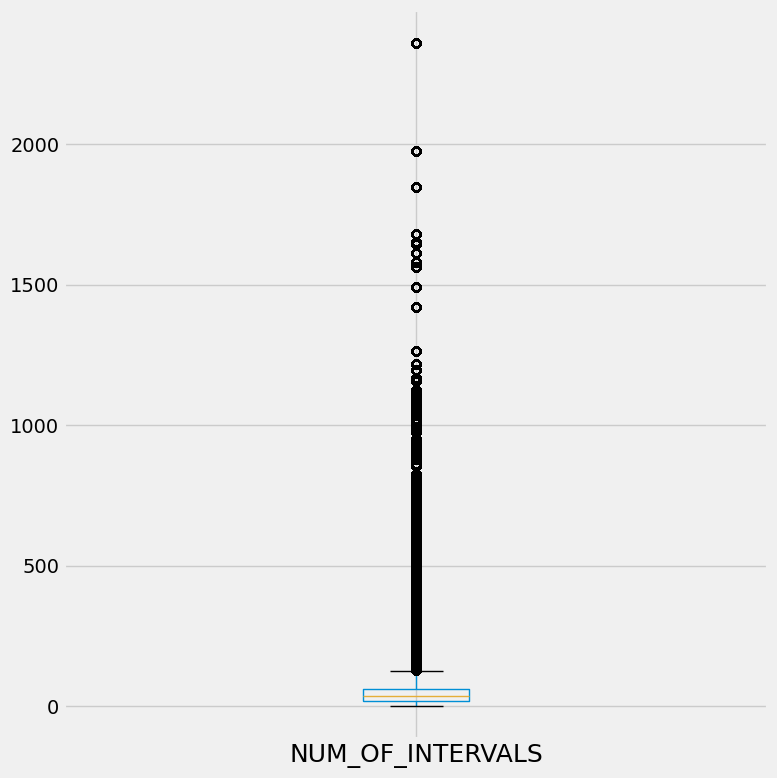

In [84]:
with plt.style.context('fivethirtyeight'):
    (
    df_after_filtering.boxplot(column = 'NUM_OF_INTERVALS', figsize = (8, 8))
    )
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('NUM_OF_INTERVALS_1.png')

Limiting the dataset to 20 intervals:

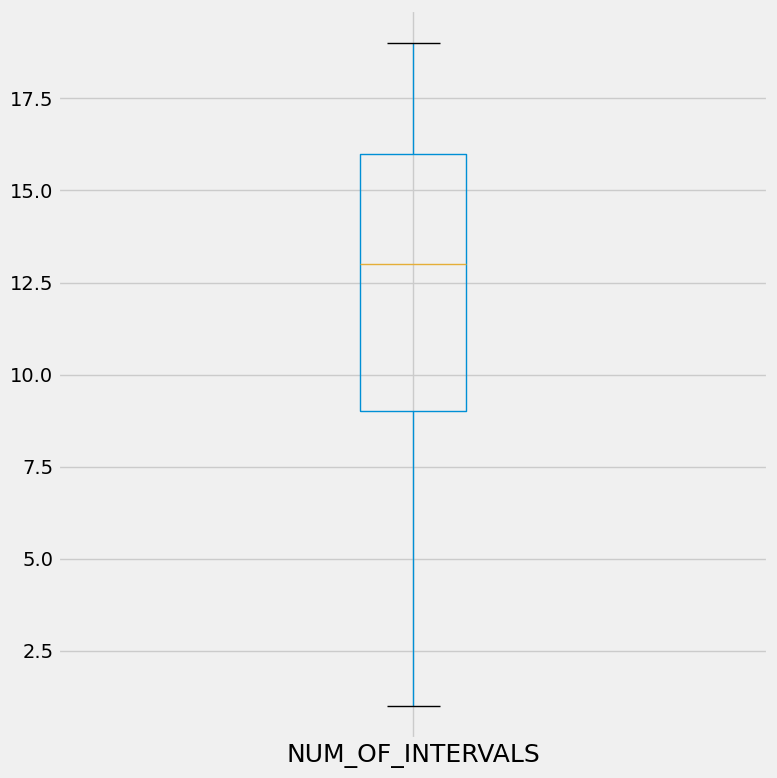

In [86]:
with plt.style.context('fivethirtyeight'):
    (
    df_after_filtering[df_after_filtering['NUM_OF_INTERVALS']<20]
        .boxplot(column = 'NUM_OF_INTERVALS', figsize = (8, 8))
    )
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('NUM_OF_INTERVALS_2.png')

I will take a slice based on whether the user has at least 9 intervals among all transactions:

In [87]:
df_after_filtering = df_after_filtering[df_after_filtering['NUM_OF_INTERVALS']>=9]

In [90]:
df_after_filtering

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,NUM_OF_INTERVALS
0,Kava,0xaf44e941991a15c712fcd8718323f36360724a798af8...,Metis,0x499601e6283366aa34d782eda01b04157010bc1c,2019-10-12 20:33:50,Merkly,8.890423e-02,NaN,93,2019-10-12,20:33:50,1,NaN,66
1,Kava,0x68faeaefcd2e56aa37673ec6779e96e00002b2813829...,Linea,0x49e5505ed54d753a55c6a43cde247e7b8fe26927,2019-10-14 06:46:10,Stargate,NaN,NaN,250,2019-10-14,06:46:10,1,NaN,111
2,Fantom,0xa29ec9e78689f5a645ed18192666fc49f8e04e66c592...,NaN,0x51edab02afb55fd7cd54b145983dc72835ad2605,2021-12-03 14:33:48,ShimmerBridge,NaN,NaN,35,2021-12-03,14:33:48,1,NaN,26
3,Fantom,0x7327972b5230ca24d30ac46ba8ed1de0a84cfff83552...,Fuse Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2021-12-03 14:33:55,Merkly,1.730753e-04,NaN,65,2021-12-03,14:33:55,1,NaN,56
4,Ethereum,0xf14eb7aead9baf48bd6604ae30de93b0af278c166250...,Avalanche,0x6d9f1a927cbcb5e2c28d13ca735bc6d6131406da,2022-09-07 14:21:51,Stargate,NaN,0.998382,844,2022-09-07,14:21:51,1,NaN,661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72587426,Core Blockchain Mainnet,0xc5894ea0414d59358dfc03f4a11ae2ade295493f35ae...,Avalanche,0xe1d144b65cd16b7305d9059f79c4586adc5d4509,2024-05-01 23:59:53,Bitcoin Bridge,NaN,NaN,117,2024-05-01,23:59:53,7,1.400000,72
72587427,Polygon,0x036061a7f480a58750a9972038942e49d3eaca351cf3...,DFK,0x820ce808b7f6f59f716eda0a97299c8e31ac791c,2024-05-01 23:59:55,Merkly,NaN,NaN,25,2024-05-01,23:59:55,4,2.966667,20
72587428,Celo Mainnet,0xe9baeb73646ca5508cb98310ca603e9f326671f11155...,Fuse Mainnet,0x38ba7226063c93a6cefcfc373eac9eedbf1bb145,2024-05-01 23:59:57,Merkly,6.041590e-07,NaN,46,2024-05-01,23:59:57,8,41.683333,31
72587429,Celo Mainnet,0x9ac6db46b4b7edcbe7ed7f7ed54e59c2b998bd38ac97...,Gnosis,0x57111a32ae4169a222836ed83f21c05927f72523,2024-05-01 23:59:57,Angle,NaN,NaN,115,2024-05-01,23:59:57,2,1.533333,51


In [89]:
gc.collect()

6651

### Calculating the median and mean for the number of transactions made each day

Median number of transactions made for all days:

In [91]:
median_txns_num_within_session = (
    df_after_filtering.groupby(['SENDER_WALLET'])['TXNS_WITHIN_DAY_COUNT']
    .median().reset_index(name='MEDIAN_TXNS_NUM_WITHIN_SESSION')
)

In [92]:
df_after_filtering = df_after_filtering.merge(median_txns_num_within_session, on='SENDER_WALLET', how='left')

In [93]:
del median_txns_num_within_session

Mean number of transactions made for all days:

In [94]:
mean_txns_num_within_session = (
    df_after_filtering.groupby(['SENDER_WALLET'])['TXNS_WITHIN_DAY_COUNT']
    .mean().reset_index(name='MEAN_TXNS_NUM_WITHIN_SESSION')
)

In [95]:
df_after_filtering = df_after_filtering.merge(mean_txns_num_within_session, on='SENDER_WALLET', how='left')

In [96]:
del mean_txns_num_within_session

The ratio of the median to the mean:

In [97]:
df_after_filtering['TXN_NUM_MEDIAN_TO_MEAN_RATIO'] = (df_after_filtering['MEAN_TXNS_NUM_WITHIN_SESSION'] /
                                                      df_after_filtering['MEDIAN_TXNS_NUM_WITHIN_SESSION']
                                                    )

In [98]:
(
    df_after_filtering.drop(columns=['MEDIAN_TXNS_NUM_WITHIN_SESSION','MEAN_TXNS_NUM_WITHIN_SESSION'],
                       inplace=True)
                              )

### Calculating the median and mean for the intervals between transactions for each day

Median:

In [99]:
median_interval_within_session = (
    df_after_filtering.groupby(['SENDER_WALLET'])['INTERVAL_MINUTES']
    .median().reset_index(name='MEDIAN_INTERVAL_WITHIN_SESSION')
)

In [100]:
df_after_filtering = df_after_filtering.merge(median_interval_within_session, on='SENDER_WALLET', how='left')

In [101]:
del median_interval_within_session

Mean:

In [102]:
mean_interval_within_session = (
    df_after_filtering.groupby(['SENDER_WALLET'])['INTERVAL_MINUTES']
    .mean().reset_index(name='MEAN_INTERVAL_WITHIN_SESSION')
)

In [103]:
df_after_filtering = df_after_filtering.merge(mean_interval_within_session, on='SENDER_WALLET', how='left')

In [104]:
del mean_interval_within_session

Ratio:

In [105]:
df_after_filtering['INTERVAL_MEDIAN_TO_MEAN_RATIO'] = (df_after_filtering['MEAN_INTERVAL_WITHIN_SESSION'] /
                                                       df_after_filtering['MEDIAN_INTERVAL_WITHIN_SESSION']
                                                    )

In [106]:
(
    df_after_filtering.drop(columns=['MEDIAN_INTERVAL_WITHIN_SESSION','MEAN_INTERVAL_WITHIN_SESSION'],
                       inplace=True)
                              )

In [107]:
df_after_filtering

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,NUM_OF_INTERVALS,TXN_NUM_MEDIAN_TO_MEAN_RATIO,INTERVAL_MEDIAN_TO_MEAN_RATIO
0,Kava,0xaf44e941991a15c712fcd8718323f36360724a798af8...,Metis,0x499601e6283366aa34d782eda01b04157010bc1c,2019-10-12 20:33:50,Merkly,8.890423e-02,NaN,93,2019-10-12,20:33:50,1,NaN,66,0.781874,12.317140
1,Kava,0x68faeaefcd2e56aa37673ec6779e96e00002b2813829...,Linea,0x49e5505ed54d753a55c6a43cde247e7b8fe26927,2019-10-14 06:46:10,Stargate,NaN,NaN,250,2019-10-14,06:46:10,1,NaN,111,1.948000,2.124195
2,Fantom,0xa29ec9e78689f5a645ed18192666fc49f8e04e66c592...,NaN,0x51edab02afb55fd7cd54b145983dc72835ad2605,2021-12-03 14:33:48,ShimmerBridge,NaN,NaN,35,2021-12-03,14:33:48,1,NaN,26,0.926531,1.390522
3,Fantom,0x7327972b5230ca24d30ac46ba8ed1de0a84cfff83552...,Fuse Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2021-12-03 14:33:55,Merkly,1.730753e-04,NaN,65,2021-12-03,14:33:55,1,NaN,56,0.837692,0.779655
4,Ethereum,0xf14eb7aead9baf48bd6604ae30de93b0af278c166250...,Avalanche,0x6d9f1a927cbcb5e2c28d13ca735bc6d6131406da,2022-09-07 14:21:51,Stargate,NaN,0.998382,844,2022-09-07,14:21:51,1,NaN,661,1.334800,13.568905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68573606,Core Blockchain Mainnet,0xc5894ea0414d59358dfc03f4a11ae2ade295493f35ae...,Avalanche,0xe1d144b65cd16b7305d9059f79c4586adc5d4509,2024-05-01 23:59:53,Bitcoin Bridge,NaN,NaN,117,2024-05-01,23:59:53,7,1.400000,72,1.233618,6.334494
68573607,Polygon,0x036061a7f480a58750a9972038942e49d3eaca351cf3...,DFK,0x820ce808b7f6f59f716eda0a97299c8e31ac791c,2024-05-01 23:59:55,Merkly,NaN,NaN,25,2024-05-01,23:59:55,4,2.966667,20,0.966667,2.329310
68573608,Celo Mainnet,0xe9baeb73646ca5508cb98310ca603e9f326671f11155...,Fuse Mainnet,0x38ba7226063c93a6cefcfc373eac9eedbf1bb145,2024-05-01 23:59:57,Merkly,6.041590e-07,NaN,46,2024-05-01,23:59:57,8,41.683333,31,0.927536,11.799096
68573609,Celo Mainnet,0x9ac6db46b4b7edcbe7ed7f7ed54e59c2b998bd38ac97...,Gnosis,0x57111a32ae4169a222836ed83f21c05927f72523,2024-05-01 23:59:57,Angle,NaN,NaN,115,2024-05-01,23:59:57,2,1.533333,51,1.186957,6.541330


#### Distribution based on calculated parameters

In [108]:
quintiles = (
    df_after_filtering[['TXN_NUM_MEDIAN_TO_MEAN_RATIO',
                     'INTERVAL_MEDIAN_TO_MEAN_RATIO']]
    .quantile([.2, .4, .6, .8]).to_dict()
)

In [109]:
quintiles

{'TXN_NUM_MEDIAN_TO_MEAN_RATIO': {0.2: 0.9107142857142857,
  0.4: 1.0727272727272728,
  0.6: 1.2666666666666666,
  0.8: 1.6},
 'INTERVAL_MEDIAN_TO_MEAN_RATIO': {0.2: 1.880141314624073,
  0.4: 3.082769350447297,
  0.6: 5.080487804878049,
  0.8: 9.438053097345131}}

#### Creating a scoring system for segmentation

For example, accounts that are in the first percentile of 20% for the parameter TXN_NUM_MEDIAN_TO_MEAN_RATIO will receive a value of 1, accounts within the second percentile - 2, and so on.

TXN_NUM_MEDIAN_TO_MEAN_RATIO

In [110]:
def t_score(x):
    if x <= quintiles['TXN_NUM_MEDIAN_TO_MEAN_RATIO'][.2]:
        return 1
    elif x <= quintiles['TXN_NUM_MEDIAN_TO_MEAN_RATIO'][.4]:
        return 2
    elif x <= quintiles['TXN_NUM_MEDIAN_TO_MEAN_RATIO'][.6]:
        return 3
    elif x <= quintiles['TXN_NUM_MEDIAN_TO_MEAN_RATIO'][.8]:
        return 4
    else:
        return 5


INTERVAL_MEDIAN_TO_MEAN_RATIO

In [111]:
def i_score(x):
    if x <= quintiles['INTERVAL_MEDIAN_TO_MEAN_RATIO'][.2]:
        return 1
    elif x <= quintiles['INTERVAL_MEDIAN_TO_MEAN_RATIO'][.4]:
        return 2
    elif x <= quintiles['INTERVAL_MEDIAN_TO_MEAN_RATIO'][.6]:
        return 3
    elif x <= quintiles['INTERVAL_MEDIAN_TO_MEAN_RATIO'][.8]:
        return 4
    else:
        return 5

In [112]:
df_after_filtering['T'] = df_after_filtering['TXN_NUM_MEDIAN_TO_MEAN_RATIO'].apply(lambda x: t_score(x))
df_after_filtering['I'] = df_after_filtering['INTERVAL_MEDIAN_TO_MEAN_RATIO'].apply(lambda x: i_score(x))


In [113]:
df_after_filtering['SCORE'] = (df_after_filtering['T'].map(str) +
                               df_after_filtering['I'].map(str)
                              )

In [114]:
(
    df_after_filtering.drop(columns=['T','I'],
                       inplace=True)
                              )

In [115]:
gc.collect()

34

In [116]:
df_after_filtering['SCORE'].value_counts()

SCORE
55    3681156
11    3605414
21    3314575
44    3188953
54    3100788
12    3055969
22    3032070
33    2894149
34    2889418
43    2863833
45    2861079
32    2757681
23    2731023
35    2630050
13    2618264
53    2607470
31    2565481
42    2544610
24    2375138
52    2324352
15    2287427
41    2264246
25    2254892
14    2160510
51    1965063
Name: count, dtype: int64

From the entire list of segments obtained, I can highlight segments 11, 21 - segments with the lowest score based on the parameters. I will examine accounts from each segment.


### Segment №1 - score "11"

In [117]:
df_after_filtering[df_after_filtering['SCORE'] == '11']['SENDER_WALLET'].unique()

array(['0x64f4575537244213160c713aeb1f8665dcb4e7ae',
       '0xe4f2ad351d990e610ce132dfd0d2857feb1308d9',
       '0xf8a69e0bf2523278874cc06fa1eed3e80a452865', ...,
       '0xa1fbe5012e1e5104d48378028d2324be8023f0dc',
       '0x15d60c7f0bdda7ef900c25b09dc877a31cd5b5ae',
       '0x41f73454e42da24e267a3013ba044db259cb36ee'], dtype=object)

In [118]:
(df_after_filtering[(df_after_filtering['SCORE'] == '11')&
                    (df_after_filtering['TXNS_COUNT'] >20)
                  ]['SENDER_WALLET'].unique())

array(['0x64f4575537244213160c713aeb1f8665dcb4e7ae',
       '0xe4f2ad351d990e610ce132dfd0d2857feb1308d9',
       '0xf8a69e0bf2523278874cc06fa1eed3e80a452865', ...,
       '0xa0bab1972199c0af9154e64a0db091c442be1b41',
       '0xa1fbe5012e1e5104d48378028d2324be8023f0dc',
       '0x15d60c7f0bdda7ef900c25b09dc877a31cd5b5ae'], dtype=object)

Example #1 from the list:

In [120]:
df_after_filtering[df_after_filtering['SENDER_WALLET'] == '0x64f4575537244213160c713aeb1f8665dcb4e7ae'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,NUM_OF_INTERVALS,TXN_NUM_MEDIAN_TO_MEAN_RATIO,INTERVAL_MEDIAN_TO_MEAN_RATIO,SCORE
3,Fantom,0x7327972b5230ca24d30ac46ba8ed1de0a84cfff83552...,Fuse Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2021-12-03 14:33:55,Merkly,0.000173,NaN,65,2021-12-03,14:33:55,1,NaN,56,0.837692,0.779655,11
51022991,Celo Mainnet,0x78a3c6ca2db98fe14cb073cf87288aa95894192b259d...,Gnosis,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2023-12-31 12:00:39,Merkly,0.016323,NaN,65,2023-12-31,12:00:39,3,NaN,56,0.837692,0.779655,11
51023156,Celo Mainnet,0x3b8b1d1864549a2bbd4e812180d06ddf238c2ad7980a...,Gnosis,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2023-12-31 12:01:29,Merkly,0.010239,NaN,65,2023-12-31,12:01:29,3,0.833333,56,0.837692,0.779655,11
51023395,Celo Mainnet,0xbba73aa0297d8856f840f28fc86ac02ec98990fb9b8e...,Gnosis,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2023-12-31 12:02:39,Merkly,0.013368,NaN,65,2023-12-31,12:02:39,3,1.166667,56,0.837692,0.779655,11
55625295,Moonriver,0x7790ae22f9df717a4abff1b9b2e711402e3bdddeb500...,Kava,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2024-01-29 06:35:54,Merkly,0.000108,NaN,65,2024-01-29,06:35:54,1,NaN,56,0.837692,0.779655,11
58876979,Gnosis,0x3bc0f796a83b82b38909b60fe42608c25816694d5561...,Celo Mainnet,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2024-02-19 10:55:45,Merkly,0.001494,NaN,65,2024-02-19,10:55:45,8,NaN,56,0.837692,0.779655,11
58882487,Moonbeam,0x3094b5a047b7c072926b660903da33eaf7e6744abe08...,DFK,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2024-02-19 11:33:30,Merkly,NaN,NaN,65,2024-02-19,11:33:30,8,37.750000,56,0.837692,0.779655,11
58882533,Moonbeam,0x36379c145c54e0de8fba320d447dd17671044bc1f333...,DFK,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2024-02-19 11:33:54,Merkly,NaN,NaN,65,2024-02-19,11:33:54,8,0.400000,56,0.837692,0.779655,11
58883014,Moonbeam,0xe7d4c22db27390b24c97524e7b9c08c54cfe5bbc4add...,DFK,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2024-02-19 11:37:12,Merkly,NaN,NaN,65,2024-02-19,11:37:12,8,3.300000,56,0.837692,0.779655,11
58883069,Moonbeam,0xf8b7a7040c2163bbeec59eea9193c7ce7b3fd4289a9e...,DFK,0x64f4575537244213160c713aeb1f8665dcb4e7ae,2024-02-19 11:37:36,Merkly,NaN,NaN,65,2024-02-19,11:37:36,8,0.400000,56,0.837692,0.779655,11


Very similar intervals, also note the weakly randomized amounts sent through Merkly.








Example #2 from the list:

In [122]:
df_after_filtering[df_after_filtering['SENDER_WALLET'] == '0xa1fbe5012e1e5104d48378028d2324be8023f0dc'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,NUM_OF_INTERVALS,TXN_NUM_MEDIAN_TO_MEAN_RATIO,INTERVAL_MEDIAN_TO_MEAN_RATIO,SCORE
68330856,Arbitrum,0x385d26ae936889758124a860e444894c66a7a08fe6a0...,Avalanche,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-29 22:03:41,Stargate,NaN,2.223546,25,2024-04-29,22:03:41,4,NaN,22,0.834,1.858801,11
68332343,Arbitrum,0xc24e8ed19bce832d2721d77024864607fd57ef1221a5...,Avalanche,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-29 22:26:08,Stargate,NaN,0.541631,25,2024-04-29,22:26:08,4,22.450000,22,0.834,1.858801,11
68332726,Arbitrum,0x78eb49a677f0fd18359378022ce767da48061c7640b6...,Avalanche,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-29 22:31:58,Stargate,NaN,0.511553,25,2024-04-29,22:31:58,4,5.833333,22,0.834,1.858801,11
68332913,Avalanche,0x4cb1ba01cc828127653e7af5be98edd8d15120ce73a9...,Arbitrum,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-29 22:34:59,Bitcoin Bridge,NaN,NaN,25,2024-04-29,22:34:59,4,3.016667,22,0.834,1.858801,11
68366357,Arbitrum,0x2cc8faf4c10464f80728076140550655a60f3bc1d308...,Aurora Mainnet,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-30 07:20:22,Gas.zip,0.091814,NaN,25,2024-04-30,07:20:22,20,NaN,22,0.834,1.858801,11
68367348,Arbitrum,0x5b52d194908c0cf8d0844241459728dcc58f9b70f314...,NaN,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-30 07:31:31,Aptos Bridge,NaN,NaN,25,2024-04-30,07:31:31,20,11.150000,22,0.834,1.858801,11
68368155,Arbitrum,0xc9d925dd87c60892e10a444f1d1dddd4a909c9af027a...,NaN,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-30 07:40:07,NaN,NaN,NaN,25,2024-04-30,07:40:07,20,8.600000,22,0.834,1.858801,11
68370043,Arbitrum,0x91dcf1342d1ea848050417099b01cf215b542f9e5bd4...,BNB Chain,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-30 07:59:00,Stargate,NaN,0.944578,25,2024-04-30,07:59:00,20,18.883333,22,0.834,1.858801,11
68372096,Arbitrum,0x8c8eb51801ff10284db64e8956d0af283183ac710f49...,BNB Chain,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-30 08:20:57,Gas.zip,0.178837,NaN,25,2024-04-30,08:20:57,20,21.950000,22,0.834,1.858801,11
68375081,Arbitrum,0x38472f700eb45b6fc82703cb4b2c2c934be3eb5291ba...,Kava,0xa1fbe5012e1e5104d48378028d2324be8023f0dc,2024-04-30 08:53:05,Merkly,0.000007,NaN,25,2024-04-30,08:53:05,20,32.133333,22,0.834,1.858801,11


Small differences between intervals, also weakly randomized amounts sent through Stargate.

Example #3 from the list:

In [123]:
df_after_filtering[df_after_filtering['SENDER_WALLET'] == '0x41f73454e42da24e267a3013ba044db259cb36ee'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,NUM_OF_INTERVALS,TXN_NUM_MEDIAN_TO_MEAN_RATIO,INTERVAL_MEDIAN_TO_MEAN_RATIO,SCORE
68389154,Celo Mainnet,0x3c30319ecaffbba59df0baad5c931a6070e243b18fa6...,Gnosis,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 11:19:11,Zerius,1.681097e-05,NaN,20,2024-04-30,11:19:11,17,NaN,18,0.876471,1.240934,11
68389742,Polygon,0x53dc92f79491129657a7b5d1eaee6fb017a546c9bb15...,Optimism,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 11:26:23,l2telegraph,NaN,NaN,20,2024-04-30,11:26:23,17,7.200000,18,0.876471,1.240934,11
68389905,Polygon,0xf679edf18829de0a7a62d0c3a7119e69d54b82bb6427...,Klaytn Mainnet Cypress,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 11:28:15,l2telegraph,NaN,NaN,20,2024-04-30,11:28:15,17,1.866667,18,0.876471,1.240934,11
68391521,Celo Mainnet,0x1172a99f2c50dbfcc0aa8143c84bfa03b8787b006dd7...,Fuse Mainnet,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 11:48:21,L2Pass,NaN,NaN,20,2024-04-30,11:48:21,17,20.100000,18,0.876471,1.240934,11
68392383,Polygon,0xd751ae7bface99b5613f24592a9d0e7e7ccd1dedac8c...,opBNB Mainnet,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 11:58:05,Merkly,1.078273e-02,NaN,20,2024-04-30,11:58:05,17,9.733333,18,0.876471,1.240934,11
68392554,Polygon,0x241d109ddd47260eec283c3faa25dd6e09c578aa7d70...,Celo Mainnet,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 12:00:07,Zerius,8.050087e-06,NaN,20,2024-04-30,12:00:07,17,2.033333,18,0.876471,1.240934,11
68392715,Polygon,0x783583359fc6f4f6d954089bfcf0f86224dba42eb462...,Optimism,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 12:02:23,L2Pass,NaN,NaN,20,2024-04-30,12:02:23,17,2.266667,18,0.876471,1.240934,11
68392933,Polygon,0xf93744a7d8cd033e00225596d873d8924e27a80bd5c3...,Orderly Mainnet,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 12:04:49,Merkly,3.043305e-02,NaN,20,2024-04-30,12:04:49,17,2.433333,18,0.876471,1.240934,11
68393150,Celo Mainnet,0x92c4f90326350b9cd5fefbab3a7b75a2b423c24ba3ce...,Gnosis,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 12:07:16,Merkly,1.265244e-05,NaN,20,2024-04-30,12:07:16,17,2.450000,18,0.876471,1.240934,11
68393815,Celo Mainnet,0x61cf0777f1a0a1b58d2b7bf7b5cd10a5c3b2d1a7ac2e...,Optimism,0x41f73454e42da24e267a3013ba044db259cb36ee,2024-04-30 12:16:36,l2telegraph,NaN,NaN,20,2024-04-30,12:16:36,17,9.333333,18,0.876471,1.240934,11


Very similar intervals with very similar small amounts, sent through different protocols.

I think it would not be a mistake to add the addresses from segment №1 with a score of "11" to the list.

### Segment №2 - score "21"

In [125]:
df_after_filtering[df_after_filtering['SCORE'] == '21']['SENDER_WALLET'].unique()

array(['0x51edab02afb55fd7cd54b145983dc72835ad2605',
       '0x498edca07cb6ef22328118aa512f275f358c7cf0',
       '0x1c910afe24e009468a66e3536d0e1e2f8437b078', ...,
       '0x7eb3d68cab999d45990166f3ae87f55aac2b20f0',
       '0x3533b6091311c5e15c59648ecfbef7cfacd62e21',
       '0xeb718ff89baa102eda5f9838d93277510396d3ad'], dtype=object)

Example #1 from the list:

In [126]:
df_after_filtering[df_after_filtering['SENDER_WALLET'] == '0x51edab02afb55fd7cd54b145983dc72835ad2605'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,NUM_OF_INTERVALS,TXN_NUM_MEDIAN_TO_MEAN_RATIO,INTERVAL_MEDIAN_TO_MEAN_RATIO,SCORE
2,Fantom,0xa29ec9e78689f5a645ed18192666fc49f8e04e66c592...,NaN,0x51edab02afb55fd7cd54b145983dc72835ad2605,2021-12-03 14:33:48,ShimmerBridge,NaN,NaN,35,2021-12-03,14:33:48,1,NaN,26,0.926531,1.390522,21
48596634,Polygon,0xd9a6d62cdec72f9d9ab81e3978d03406865b84a1f993...,BNB Chain,0x51edab02afb55fd7cd54b145983dc72835ad2605,2023-12-16 14:07:38,Stargate,0.187514,NaN,35,2023-12-16,14:07:38,1,NaN,26,0.926531,1.390522,21
58784075,Base,0xebf0886cde459644da5d641afb1a4e2de578295ee905...,Linea,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 20:43:03,Stargate,NaN,4181.272203,35,2024-02-18,20:43:03,8,NaN,26,0.926531,1.390522,21
58786228,Linea,0x1af0c713472805bab880492220ddd76640469ce6c243...,Arbitrum,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 21:00:48,Stargate,NaN,4150.629968,35,2024-02-18,21:00:48,8,17.750000,26,0.926531,1.390522,21
58787135,Arbitrum,0xcf651f14fd0f7c6c37a4cfce0c5470b5236e658316a7...,Optimism,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 21:08:29,Stargate,NaN,4137.842314,35,2024-02-18,21:08:29,8,7.683333,26,0.926531,1.390522,21
58787844,Optimism,0x1489accce74d623ab674c3945869be87b6502213318a...,Base,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 21:14:53,Stargate,NaN,4170.129572,35,2024-02-18,21:14:53,8,6.400000,26,0.926531,1.390522,21
58788983,Base,0x4adf856c34c3ede406c538546a419621b5d9afa71fec...,Linea,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 21:24:19,Stargate,NaN,4152.022797,35,2024-02-18,21:24:19,8,9.433333,26,0.926531,1.390522,21
58789219,Linea,0x796d803a459afa2b4bca48d178045141fae20fe21424...,Optimism,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 21:26:28,Stargate,NaN,4158.986941,35,2024-02-18,21:26:28,8,2.150000,26,0.926531,1.390522,21
58791452,Optimism,0x651488f4ab8ab25b5f80127053e6500602f202430ba2...,Linea,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 21:46:23,Stargate,NaN,4011.347083,35,2024-02-18,21:46:23,8,19.916667,26,0.926531,1.390522,21
58792295,Linea,0xc5ace248b6d07909d75d09c60fef7ddcd12f802a5a53...,Optimism,0x51edab02afb55fd7cd54b145983dc72835ad2605,2024-02-18 21:53:44,Stargate,NaN,4139.487337,35,2024-02-18,21:53:44,8,7.350000,26,0.926531,1.390522,21


Again, intervals close in value and almost identical amounts sent through Stargate.

Example #2 from the list:

In [129]:
df_after_filtering[df_after_filtering['SENDER_WALLET'] == '0x1c910afe24e009468a66e3536d0e1e2f8437b078'].head(60)

,SOURCE_CHAIN,SOURCE_TRANSACTION_HASH,DESTINATION_CHAIN,SENDER_WALLET,SOURCE_TIMESTAMP_UTC,PROJECT,NATIVE_DROP_USD,STARGATE_SWAP_USD,TXNS_COUNT,DATE,TIME,TXNS_WITHIN_DAY_COUNT,INTERVAL_MINUTES,NUM_OF_INTERVALS,TXN_NUM_MEDIAN_TO_MEAN_RATIO,INTERVAL_MEDIAN_TO_MEAN_RATIO,SCORE
53,BNB Chain,0xaf8013e94d1804526929b9eaaa225c50701a4ea15560...,Polygon,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2022-09-07 16:28:01,Stargate,NaN,NaN,69,2022-09-07,16:28:01,2,NaN,35,1.019324,1.72155,21
56,Polygon,0x5f75a3db8fd91c99dd6e6c2ff98d1e071dbc714a71be...,BNB Chain,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2022-09-07 16:32:01,Stargate,NaN,NaN,69,2022-09-07,16:32:01,2,4.000000,35,1.019324,1.72155,21
910382,Optimism,0x3545036f8107e482dc2b47f74d9f81dd81ec0d9acdde...,Arbitrum,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-03-24 15:18:07,Stargate,NaN,5323.082126,69,2023-03-24,15:18:07,2,NaN,35,1.019324,1.72155,21
910476,Arbitrum,0xea61b5bd16dd6c92db39121ef02fd8b758f4ea9572f4...,Optimism,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-03-24 15:25:42,Stargate,NaN,10545.866370,69,2023-03-24,15:25:42,2,7.583333,35,1.019324,1.72155,21
1186002,Avalanche,0x80026768a3aa856cedae090c85768ba24d4c7acd3f09...,Polygon,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-04-04 02:13:30,Holograph,NaN,NaN,69,2023-04-04,02:13:30,4,NaN,35,1.019324,1.72155,21
1186298,Arbitrum,0x8f045a5cd39f199e36fa1f8027415eef8ad518a6a6ef...,Optimism,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-04-04 02:29:14,Stargate,NaN,2026.505573,69,2023-04-04,02:29:14,4,15.733333,35,1.019324,1.72155,21
1186471,Optimism,0x0b57c96bdbebe49f2768b52401835e555e1fa3aa75fb...,Arbitrum,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-04-04 02:37:46,Stargate,NaN,2008.411773,69,2023-04-04,02:37:46,4,8.533333,35,1.019324,1.72155,21
1186719,Arbitrum,0x50d658232cd02e43ec56415befd91c71bbff934a1035...,Optimism,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-04-04 02:52:53,Stargate,NaN,0.146413,69,2023-04-04,02:52:53,4,15.116667,35,1.019324,1.72155,21
1335991,Avalanche,0xb4d75b94641b3f6fa647b7a1367fa56190f4f26df7a8...,Polygon,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-04-06 06:46:10,Holograph,NaN,NaN,69,2023-04-06,06:46:10,2,NaN,35,1.019324,1.72155,21
1336457,Avalanche,0x1390e6b83e7170f3be1d1c6e9985c4c66c7c82de2485...,Polygon,0x1c910afe24e009468a66e3536d0e1e2f8437b078,2023-04-06 06:49:46,Holograph,NaN,NaN,69,2023-04-06,06:49:46,2,3.600000,35,1.019324,1.72155,21


Again, intervals close in value and almost identical amounts sent. There are short intervals - 50, 30 seconds, and others.








**I think it would not be a mistake to add the addresses from segment №1 with a score of "21" to the list.**

### List Formation

Accounts with randomization scoring "11":

In [130]:
score_11 = df_after_filtering[df_after_filtering['SCORE'] == '11']['SENDER_WALLET'].unique().tolist()

In [131]:
len(score_11)

98403

Accounts with randomization scoring "21":

In [132]:
score_21 = df_after_filtering[df_after_filtering['SCORE'] == '21']['SENDER_WALLET'].unique().tolist()

In [133]:
len(score_21)

78322

In [134]:
score_11.extend(score_21)

In [135]:
list_of_sybils_with_weak_randomisation = score_11

In [136]:
len(list_of_sybils_with_weak_randomisation)

176725

In [137]:
with open('sybils_second_list.txt', 'w') as file:
    for item in list_of_sybils_with_weak_randomisation:
        file.write("%s\n" % item)